In [3]:
import os
import hist
import uproot
import numpy as np
import argparse
import awkward as ak
import matplotlib.pyplot as plt
from   time import time
from   uncertainties import ufloat, unumpy
from   ROOT import TFile, TH1D, TH2D, TUnfoldBinning, TUnfoldBinningXML

import uproot
from ROOT import TFile, TH1D, TH2D
import hist
import os
import numpy as np
import argparse
from array import array
import awkward as ak
from uncertainties import ufloat, unumpy
import matplotlib.pyplot as plt
import mplhep

In [4]:
def remove_underoverflow(histogram, doGen = 1 , doReco = 1):

    if len(histogram.shape) == 1:
        
        x_range = len(histogram[:]) - 1

        histogram[1] = histogram[0] + histogram[1]
        histogram[0] = histogram[0] - histogram[0]
    
        histogram[x_range - 1] = histogram[x_range] + histogram[x_range - 1]
        histogram[x_range] = histogram[x_range] - histogram[x_range]
    
    elif len(histogram.shape) == 2:
        
        x_range = len(histogram[:,0]) - 1 
        y_range = len(histogram[0,:]) - 1
        
        if doGen:
            histogram[1,:] = histogram[0,:] + histogram[1,:]
            histogram[0,:] = histogram[0,:] - histogram[0,:]
        
        if doReco:
            histogram[:,1] = histogram[:,0] + histogram[:,1]
            histogram[:,0] = histogram[:,0] - histogram[:,0]
    
        if doGen:
            histogram[x_range - 1,:] = histogram[x_range,:] + histogram[x_range - 1,:]
            histogram[x_range,:] = histogram[x_range,:] - histogram[x_range,:]

        if doReco:
            histogram[:,y_range - 1] = histogram[:,y_range] + histogram[:,y_range - 1]
            histogram[:,y_range] = histogram[:,y_range] - histogram[:,y_range]
        
        
    elif len(histogram.shape) == 3:
        
        x_range = len(histogram[:,0,0]) - 1
        y_range = len(histogram[0,:,0]) - 1
        z_range = len(histogram[0,0,:]) - 1

        histogram[1,:,:] = histogram[0,:,:] + histogram[1,:,:]
        histogram[0,:,:] = histogram[0,:,:] - histogram[0,:,:]
        histogram[:,1,:] = histogram[:,0,:] + histogram[:,1,:]
        histogram[:,0,:] = histogram[:,0,:] - histogram[:,0,:]
        histogram[:,:,1] = histogram[:,:,0] + histogram[:,:,1]
        histogram[:,:,0] = histogram[:,:,0] - histogram[:,:,0]
    
        histogram[x_range - 1,:,:] = histogram[x_range,:,:] + histogram[x_range - 1,:,:]
        histogram[x_range,:,:] = histogram[x_range,:,:] - histogram[x_range,:,:]
        histogram[:,y_range - 1,:] = histogram[:,y_range,:] + histogram[:,y_range - 1,:]
        histogram[:,y_range,:] = histogram[:,y_range,:] - histogram[:,y_range,:]
        histogram[:,:,z_range - 1] = histogram[:,:,z_range] + histogram[:,:,z_range - 1]
        histogram[:,:,z_range] = histogram[:,:,z_range] - histogram[:,:,z_range]
        
    elif len(histogram.shape) == 4:

        w_range = len(histogram[:,0,0,0]) - 1
        x_range = len(histogram[0,:,0,0]) - 1
        y_range = len(histogram[0,0,:,0]) - 1
        z_range = len(histogram[0,0,0,:]) - 1

        if doGen:
            histogram[1,:,:,:] = histogram[0,:,:,:] + histogram[1,:,:,:]
            histogram[0,:,:,:] = histogram[0,:,:,:] - histogram[0,:,:,:]
            histogram[:,1,:,:] = histogram[:,0,:,:] + histogram[:,1,:,:]
            histogram[:,0,:,:] = histogram[:,0,:,:] - histogram[:,0,:,:]
        
        if doReco:
            histogram[:,:,1,:] = histogram[:,:,0,:] + histogram[:,:,1,:]
            histogram[:,:,0,:] = histogram[:,:,0,:] - histogram[:,:,0,:]
            histogram[:,:,:,1] = histogram[:,:,:,0] + histogram[:,:,:,1]
            histogram[:,:,:,0] = histogram[:,:,:,0] - histogram[:,:,:,0]

        if doGen:
            histogram[w_range - 1,:,:,:] = histogram[w_range,:,:,:] + histogram[w_range - 1,:,:,:]
            histogram[w_range,:,:,:] = histogram[w_range,:,:,:] - histogram[w_range,:,:,:]
            histogram[:,x_range - 1,:,:] = histogram[:,x_range,:,:] + histogram[:,x_range - 1,:,:]
            histogram[:,x_range,:,:] = histogram[:,x_range,:,:] - histogram[:,x_range,:,:]

        if doReco:
            histogram[:,:,y_range - 1,:] = histogram[:,:,y_range,:] + histogram[:,:,y_range - 1,:]
            histogram[:,:,y_range,:] = histogram[:,:,y_range,:] - histogram[:,:,y_range,:]
            histogram[:,:,:,z_range - 1] = histogram[:,:,:,z_range] + histogram[:,:,:,z_range - 1]
            histogram[:,:,:,z_range] = histogram[:,:,:,z_range] - histogram[:,:,:,z_range]
    
    return histogram

In [5]:
def compute_response_matrix(var_name, gen_axes, reco_axes, gen_step8_data, step8_data, gen_step0_data, gen_step8_weights, step8_weights, gen_step0_weights):

    axes = gen_axes + reco_axes

    response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())
    response_matrix_genUnderflow = hist.Hist(*axes, storage=hist.storage.Weight())
    response_matrix_genUnderflowCorrection = hist.Hist(*axes, storage=hist.storage.Weight())

    # fill the reconstructed events
    response_matrix.fill(*gen_step8_data + step8_data, weight=step8_weights)
    
    #remove_underoverflow(response_matrix.values(flow=True))    
    #remove_underoverflow(response_matrix.variances(flow=True))

    # fill the generator level events in the reconstruction underflow bin
    # this is back at step0 so that we can unfold back to full phase space
    response_matrix_genUnderflow.fill(*gen_step0_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step0_data[0])) for j in range(0,len(reco_axes))], weight=gen_step0_weights)
    #remove_underoverflow(response_matrix_genUnderflow.values(flow=True), 1, 0)    
    #remove_underoverflow(response_matrix_genUnderflow.variances(flow=True), 1, 0)
    
    # next create a separate response matrix to fill the reco weights
    # this is because we need to subtract the entries AND variances and can't
    # do that with a "simple" negative weight (this would only subtract entries,
    # variances are sum of weights squared)

    # fill this new matrix
    response_matrix_genUnderflowCorrection.fill(*gen_step8_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step8_data[0])) for j in range(0,len(reco_axes))], weight=step8_weights)
    #remove_underoverflow(response_matrix_genUnderflowCorrection.values(flow=True), 1, 0)    
    #remove_underoverflow(response_matrix_genUnderflowCorrection.variances(flow=True), 1, 0)
    
    # set values and variances equal to the difference between response_matrix
    # and _response_matrix to account for these events that aren't reconstructed
    response_matrix[...] = np.concatenate(
        ((response_matrix.values(flow=True) + response_matrix_genUnderflow.values(flow=True) - response_matrix_genUnderflowCorrection.values(flow=True))[..., None],
         (response_matrix.variances(flow=True) + response_matrix_genUnderflow.variances(flow=True) - response_matrix_genUnderflowCorrection.variances(flow=True))[..., None]),
        axis=len(axes)
    )

    return response_matrix


In [6]:
def compute_reco(var_name, reco_axes, step8_data, step8_weights, symmetrize = False):
    
    reco = hist.Hist(*reco_axes, storage=hist.storage.Weight())
    
    if symmetrize == False:
        reco.fill(*step8_data, weight=step8_weights)
    elif symmetrize == True:
        reco.fill(*[1.0*np.array(step8_data[0])] + [data for data in step8_data[1:] if step8_data[1:]], weight=(0.5*np.array(step8_weights)))
        reco.fill(*[-1.0*np.array(step8_data[0])] + [data for data in step8_data[1:] if step8_data[1:]], weight=(0.5*np.array(step8_weights)))
        reco.variances(flow=True)[...] = 2.0 * reco.variances(flow=True)[...] 
    remove_underoverflow(reco.values(flow=True))    
    remove_underoverflow(reco.variances(flow=True))
    
    return reco

In [7]:
def compute_gen(var_name, gen_axes, gen_step0_data, gen_step0_weights):
    
    gen = hist.Hist(*gen_axes, storage=hist.storage.Weight())
    
    gen.fill(*gen_step0_data, weight=gen_step0_weights)
    
    remove_underoverflow(gen.values(flow=True))    
    remove_underoverflow(gen.variances(flow=True))

    return gen

In [8]:
def compute_resolution(var_name, residual_axes, gen_axes, step8_data, gen_step8_data, step8_weights):
    
    axes = residual_axes + gen_axes
    
    resolution = hist.Hist(*axes, storage=hist.storage.Weight())
    resolution.fill(*np.subtract(step8_data, gen_step8_data), *gen_step8_data, weight=step8_weights)
    
    remove_underoverflow(resolution.values(flow=True))    
    remove_underoverflow(resolution.variances(flow=True))
    
    return resolution

In [9]:
# era = '2016ULpostVFP'

# #filename = 'emu_ttbarsignalplustau_fromDilepton_2017UL_0.root'
# #dir_name = '/mnt/hadoop/store/group/local/cmstop/jthiema/2017/spinCorrInput_2017UL_DeepJet_August2022'

# #filename = 'emu_ttbarsignalplustau.root'
# #dir_name = '/mnt/hadoop/store/group/local/cmstop/jthiema/2016_old/spinCorrInputUnsymmetrized_2016'

# filename = 'emu_ttbarsignalplustau_fromDilepton_2016ULpostVFP_0.root'
# dir_name = '/depot/cms/top/jthiema/AnalysisFramework/TopSpinCorr_FullRunIIUL_September2022/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/spinCorrInput_2016postVFP'

# systematic = 'Nominal'
# channel = 'emu'

In [10]:
# dileptonic_dir          = "/depot/cms/top/jthiema/AnalysisFramework/TopSpinCorr_FullRunIIUL_April2022/CMSSW_10_6_29/src/TopAnalysis/Configuration/analysis/diLeptonic"
# TUnfoldFileLists_dir     = "TUnfoldFileLists_"+era.replace("UL","")
# TUnfoldFileList_filename = "TUnfoldFileList_"+systematic+"_"+channel+".txt"

# TUnfoldFileList = open(dileptonic_dir + "/" + TUnfoldFileLists_dir + "/" + TUnfoldFileList_filename, "r")

# filelist        = TUnfoldFileList.readlines()

# for file in filelist:
#     print("Processing: " + file)

In [11]:
file = "/depot/cms/top/jthiema/AnalysisFramework/TopSpinCorr_FullRunIIUL_September2022/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/spinCorrInput_2016postVFP/Nominal/emu/emu_ttbarsignalplustau_fromDilepton_2016ULpostVFP_0.root"

# open the minitree
step0tree = uproot.open(file+':ttBar_treeVariables_step0')
step8tree = uproot.open(file+':ttBar_treeVariables_step8')

In [12]:
weightedEvents = uproot.open(file+':weightedEvents')
print(weightedEvents)

<TH1D (version 3) at 0x7f24f4456bf0>


In [13]:
tree_vars = [
    "ll_cHel","ll_cLab","llbar_delta_phi","llbar_delta_eta",
    "b1k","b2k","b1r","b2r","b1n","b2n","b1j","b2j","b1q","b2q",
    "c_kk","c_rr","c_nn","c_kj","c_rq","c_rq",   
    "c_rk","c_kr","c_nr","c_rn","c_nk","c_kn",
#    "c_rj","c_jr",
    
    "gen_ll_cHel","gen_ll_cLab","gen_llbar_delta_phi","gen_llbar_delta_eta",
    "gen_b1k","gen_b2k","gen_b1r","gen_b2r","gen_b1n","gen_b2n","gen_b1j","gen_b2j","gen_b1q","gen_b2q",
    "gen_c_kk","gen_c_rr","gen_c_nn","gen_c_kj","gen_c_rq","gen_c_rq",   
    "gen_c_rk","gen_c_kr","gen_c_nr","gen_c_rn","gen_c_nk","gen_c_kn",
#    "gen_c_rj","gen_c_jr",
    
    "eventWeight", "trueLevelWeight", "entry",
    "gen_ttbar_mass", "gen_top_scatteringangle_ttbarframe",
    "ttbar_mass", "top_scatteringangle_ttbarframe",

    "gen_l_pt", "gen_lbar_pt", "gen_l_eta", "gen_lbar_eta", 
    "gen_b_pt", "gen_bbar_pt", "gen_b_eta", "gen_bbar_eta",
    "gen_l_pdgid", "gen_lbar_pdgid",
    ]

In [14]:
step0 = ak.Array(
    ak.zip( dict( (var, step0tree[var].array()) for var in tree_vars ) )
)

#step0_mask = (step0.gen_l_pdgid*step0.gen_lbar_pdgid == -11*13)
#step0 = step0_raw[step0_mask]
#print(len(step0))

step8 = ak.Array(
    ak.zip( dict( (tree_var, step8tree[tree_var].array()) for tree_var in tree_vars ) )
)

In [15]:
vars_dict = {
    "c_kk" : {"bin_edge_low" : -1.0, 
                 "bin_edge_high" : 1.0, 
                 "n_gen_bins"  : 24, 
                 "n_reco_bins" : 48, 
                 "residual_bin_edge_low" : -2.0, 
                 "residual_bin_edge_high" : 2.0, 
                 "n_residual_bins" : 20,
                 "gen_val_0" : step0["gen_c_kk"],
                 "val_8"     : step8["c_kk"],
                 "gen_val_8" : step8["gen_c_kk"], 
                },

    "b1k" : {    "bin_edge_low" : -1.0, 
                 "bin_edge_high" : 1.0, 
                 "n_gen_bins"  : 24, 
                 "n_reco_bins" : 48, 
                 "residual_bin_edge_low" : -2.0, 
                 "residual_bin_edge_high" : 2.0, 
                 "n_residual_bins" : 20,
                 "gen_val_0" : step0["gen_b1k"],
                 "val_8"     : step8["b1k"],
                 "gen_val_8" : step8["gen_b1k"], 
                },
}


In [16]:
varname = "b1k"

In [17]:
gen_axes      = [hist.axis.Regular(vars_dict[varname]["n_gen_bins"]     , vars_dict[varname]["bin_edge_low"], vars_dict[varname]["bin_edge_high"], name="gen_" + varname, label="gen_" + varname, underflow=True, overflow=True),]
reco_axes     = [hist.axis.Regular(vars_dict[varname]["n_reco_bins"]    , vars_dict[varname]["bin_edge_low"], vars_dict[varname]["bin_edge_high"], name="reco_"+ varname, label="reco_"+ varname, underflow=True, overflow=True)]
residual_axes = [hist.axis.Regular(vars_dict[varname]["n_residual_bins"], vars_dict[varname]["residual_bin_edge_low"], vars_dict[varname]["residual_bin_edge_high"], name="residual_" + varname, label="residual_" + varname, underflow=True, overflow=True)]
visgen_axes   = [hist.axis.Regular(vars_dict[varname]["n_gen_bins"]     , vars_dict[varname]["bin_edge_low"], vars_dict[varname]["bin_edge_high"], name="visgen_" + varname, label="visgen_" + varname, underflow=True, overflow=True),]

In [18]:
# fill the reconstructed events

gen_step8_data = [vars_dict[varname]["gen_val_8"]]
gen_step0_data = [vars_dict[varname]["gen_val_0"]]
step8_data     = [vars_dict[varname]["val_8"]]

gen_step8_weights = [step8['trueLevelWeight']]
gen_step0_weights = [step0['trueLevelWeight']]
step8_weights     = [step8['eventWeight']]

axes = gen_axes + reco_axes

response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())
response_matrix_genUnderflow = hist.Hist(*axes, storage=hist.storage.Weight())
response_matrix_genUnderflowCorrection = hist.Hist(*axes, storage=hist.storage.Weight())
    
response_matrix.fill(*gen_step8_data + step8_data, weight=step8_weights)

#remove_underoverflow(response_matrix.values(flow=True))    
#remove_underoverflow(response_matrix.variances(flow=True))

# fill the generator level events in the reconstruction underflow bin
# this is back at step0 so that we can unfold back to full phase space
response_matrix_genUnderflow.fill(*gen_step0_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step0_data[0])) for j in range(0,len(reco_axes))], weight=gen_step0_weights)
#remove_underoverflow(response_matrix_genUnderflow.values(flow=True), 1, 0)    
#remove_underoverflow(response_matrix_genUnderflow.variances(flow=True), 1, 0)

# next create a separate response matrix to fill the reco weights
# this is because we need to subtract the entries AND variances and can't
# do that with a "simple" negative weight (this would only subtract entries,
# variances are sum of weights squared)

# fill this new matrix
response_matrix_genUnderflowCorrection.fill(*gen_step8_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step8_data[0])) for j in range(0,len(reco_axes))], weight=step8_weights)
#remove_underoverflow(response_matrix_genUnderflowCorrection.values(flow=True), 1, 0)    
#remove_underoverflow(response_matrix_genUnderflowCorrection.variances(flow=True), 1, 0)

# set values and variances equal to the difference between response_matrix
# and _response_matrix to account for these events that aren't reconstructed
response_matrix[...] = np.concatenate(
    (( response_matrix.values(flow=True)    + response_matrix_genUnderflow.values(flow=True)    - response_matrix_genUnderflowCorrection.values(flow=True))[..., None],
    (  response_matrix.variances(flow=True) + response_matrix_genUnderflow.variances(flow=True) - response_matrix_genUnderflowCorrection.variances(flow=True))[..., None]),
    axis=len(axes)
)

In [19]:
gen_step8_data + step8_data

[<Array [-0.304, 0.848, ... 0.279, 0.998] type='104435 * float32'>,
 <Array [-0.157, 0.785, ... -0.281, 0.931] type='104435 * float32'>]

In [24]:
reco_axes[0]

Regular(48, -1, 1, name='reco_b1k')

In [20]:
gen_step0_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step0_data[0])) for j in range(0,len(reco_axes))]

[<Array [-0.304, 0.904, 0.147, ... 0.998, 0.818] type='518926 * float32'>,
 array([-2., -2., -2., ..., -2., -2., -2.])]

In [25]:
gen_step8_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step8_data[0])) for j in range(0,len(reco_axes))]

[<Array [-0.304, 0.848, ... 0.279, 0.998] type='104435 * float32'>,
 array([-2., -2., -2., ..., -2., -2., -2.])]

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f23cb9fb190>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f23cb9fb1c0>, text=[])

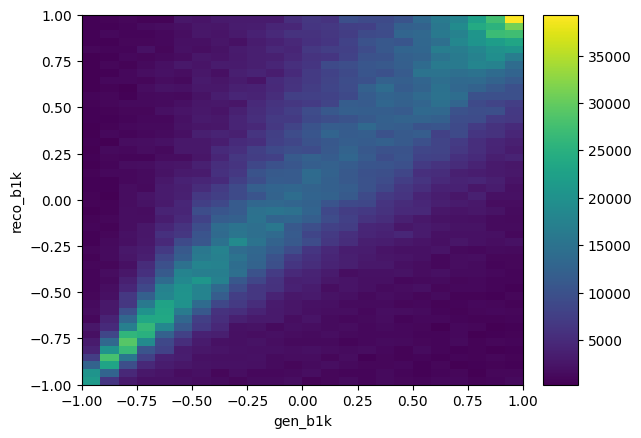

In [26]:
response_matrix.plot()

In [31]:
response_matrix_genUnderflow.values(flow=True)

array([[      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [1564487.26631391,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [1530229.05498886,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       ...,
       [1555751.39526367,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [1572164.87751233,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])

In [29]:
response_matrix_genUnderflowCorrection.values(flow=True)

array([[     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [ 99698.79772536,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [161377.3660984 ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [294193.35059929,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [292978.3971138 ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f3ebc17a200>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f3ebc17a620>, text=[])

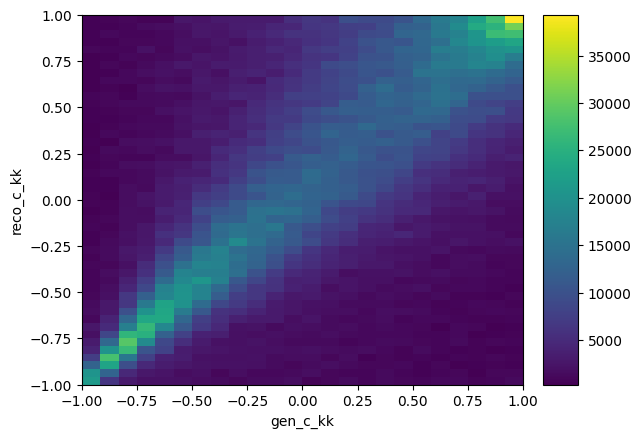

In [55]:
resmat = compute_response_matrix("b1k", gen_axes, reco_axes, [vars_dict["b1k"]["gen_val_8"]], [vars_dict["b1k"]["val_8"]], [vars_dict["b1k"]["gen_val_0"]], [step8['trueLevelWeight']], [step8['eventWeight']], [step0['trueLevelWeight']])
resmat.plot()
#resmat.view(flow=True)

In [56]:
response_matrix.to_numpy()[0]

array([[ 131.90553665,  320.40330124,  275.6454277 , ...,    0.        ,
           0.        ,    0.        ],
       [ 120.88492584,  336.99887848, 1575.40509415, ...,    0.        ,
           0.        ,    0.        ],
       [  65.90005493,  700.8882103 , 2020.83544159, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1087.9970932 ,
         488.11012268,  174.12950134],
       [   0.        ,    0.        ,    0.        , ...,  714.04791641,
         360.15283203,  345.13310623],
       [   0.        ,    0.        ,    0.        , ...,  426.8972435 ,
         134.3991394 ,   73.69062805]])

In [85]:
# W/o symmterization 
fileptr_FW = uproot.open("/depot/cms/top/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/UnfoldingHistos_2016preVFP/Nominal/ee/histosTUnfold_ee_ttbarsignalplustau_fromDilepton_2016ULpreVFP.root")

In [86]:
response_matrix_FW = fileptr_FW["hrecoVsgen_b1k"].to_hist()

In [87]:
response_matrix

Hist(
  Regular(24, -1, 1, name='gen_b1k'),
  Regular(48, -1, 1, name='reco_b1k'),
  storage=Weight()) # Sum: WeightedSum(value=6.89395e+06, variance=4.68926e+08) (WeightedSum(value=3.74108e+07, variance=2.77598e+09) with flow)

In [88]:
response_matrix_FW

Hist(
  Regular(24, 0.5, 24.5, name='xaxis', label='ttbargen'),
  Regular(48, 0.5, 48.5, name='yaxis', label='ttbarreco'),
  storage=Weight()) # Sum: WeightedSum(value=2.51481e+07, variance=1.72704e+09) (WeightedSum(value=3.0018e+08, variance=2.22575e+10) with flow)

In [89]:
Jason_gen = response_matrix.project('gen_b1k').to_numpy()[0]
FW_gen    = response_matrix_FW.project('xaxis').to_numpy()[0]

In [90]:
Jason_gen_normed = Jason_gen / sum(Jason_gen)
FW_gen_normed    = FW_gen / sum(FW_gen)

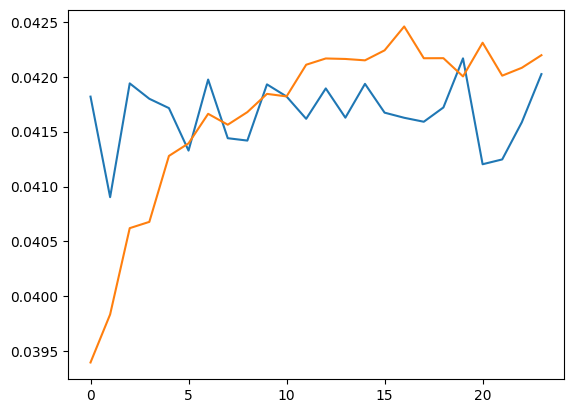

In [91]:
plt.plot(Jason_gen_normed)
plt.plot(FW_gen_normed)

In [82]:
Jason_gen_normed[6:12]

array([0.04197456, 0.0414404 , 0.04141875, 0.04193075, 0.04182019,
       0.04161698])

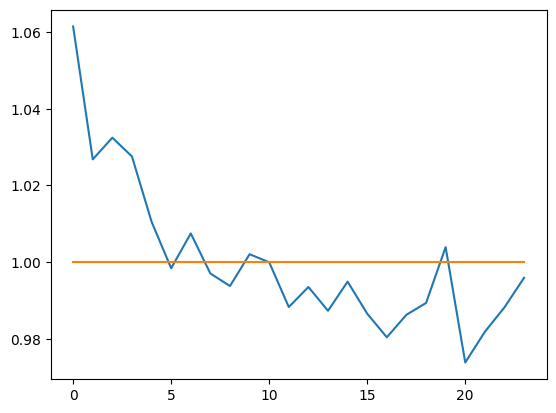

In [92]:
plt.plot(np.divide(Jason_gen_normed, FW_gen_normed))
plt.plot(np.ones(len(FW_gen_normed)))

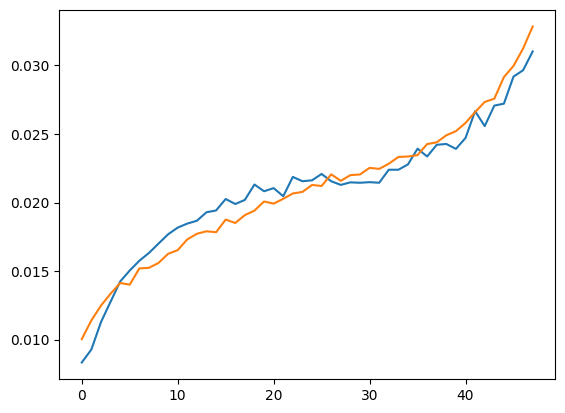

In [93]:
Jason_reco = response_matrix.project('reco_b1k').to_numpy()[0]
FW_reco    = response_matrix_FW.project('yaxis').to_numpy()[0]

Jason_reco_normed = Jason_reco / sum(Jason_reco)
FW_reco_normed    = FW_reco / sum(FW_reco)

plt.plot(Jason_reco_normed)
plt.plot(FW_reco_normed)

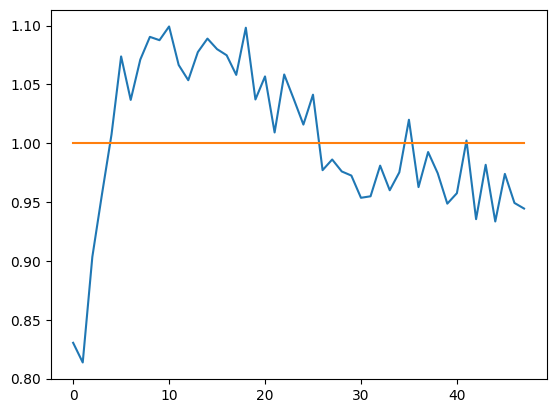

In [94]:
plt.plot(np.divide(Jason_reco_normed, FW_reco_normed))
plt.plot(np.ones(len(FW_reco_normed)))

In [15]:
def Convert_to_TH2(prefix, var, hist2D):

    TH2 = TH2D(prefix+"_"+var, 
               prefix+"_"+var, 
               hist2D.values(flow=False).shape[0], 
               vars_dict[var]["bin_edge_low"], 
               vars_dict[var]["bin_edge_high"],
               hist2D.values(flow=False).shape[1], 
               vars_dict[var]["bin_edge_low"], 
               vars_dict[var]["bin_edge_high"]
              )
    TH2.Sumw2()
    
    i_range = hist2D.values(flow=False).shape[0]+1
    j_range = hist2D.values(flow=False).shape[1]+1

    for i in range(0,i_range):
        for j in range(0,j_range):
            TH2.SetBinContent(i,j,hist2D.values(flow=True)[i,j])
            TH2.SetBinError(i,j,np.sqrt(hist2D.variances(flow=True)[i,j]))

    return TH2

In [35]:
print(0.5*np.array([vars_dict["c_kk"]["val_8"]]))

[[-0.03529958  0.07242516  0.29443428 ...  0.03986717  0.07115263
   0.3994624 ]]


WeightedSumView(
      [(      0.        , 0.00000000e+00),
       ( 196807.56356144, 1.33624750e+07),
       ( 807535.03640847, 5.49267202e+07),
       (2442631.68793726, 1.66173882e+08),
       (2442631.68793726, 1.66173882e+08),
       ( 807535.03640847, 5.49267202e+07),
       ( 196807.56356144, 1.33624750e+07),
       (      0.        , 0.00000000e+00)],
      dtype=[('value', '<f8'), ('variance', '<f8')])

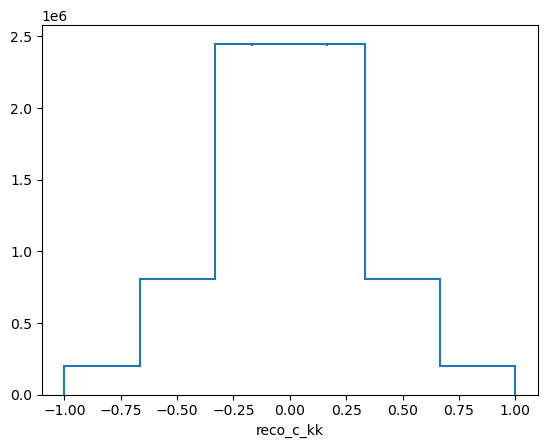

In [89]:

reco = compute_reco('c_kk', reco_axes, [vars_dict["c_kk"]["val_8"]], [step8['eventWeight']], True)
reco.plot()
reco.view(flow=True)
#reco

WeightedSumView(
      [(      0.        , 0.00000000e+00),
       ( 243554.57153511, 1.64450578e+07),
       ( 986518.76246802, 6.68701987e+07),
       (2627284.54868793, 1.78669391e+08),
       (2257978.82718658, 1.53678374e+08),
       ( 628551.31034893, 4.29832417e+07),
       ( 150060.55558777, 1.02798922e+07),
       (      0.        , 0.00000000e+00)],
      dtype=[('value', '<f8'), ('variance', '<f8')])

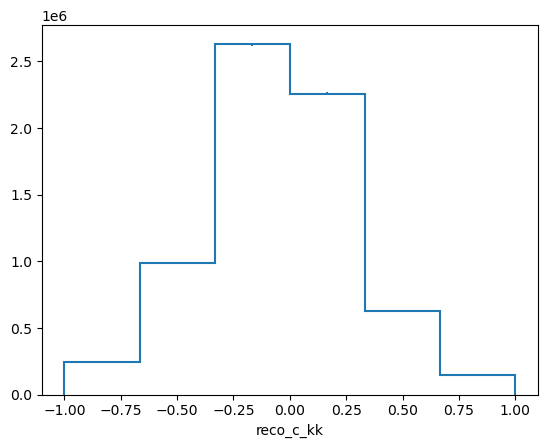

In [90]:

reco = compute_reco('c_kk', reco_axes, [vars_dict["c_kk"]["val_8"]], [step8['eventWeight']], False)
reco
reco.plot()
reco.view(flow=True)

In [ ]:
gen = compute_reco('ll_cHel', gen_axes, [vars_dict["ll_cHel"]["gen_val_0"]], [step0['trueLevelWeight']])
gen.plot()
gen.view(flow=True)
gen

In [ ]:
resolution = compute_resolution('c_kk', residual_axes, gen_axes, [vars_dict["c_kk"]["val_8"]], [vars_dict["c_kk"]["gen_val_8"]], [step8['eventWeight']])
resolution.plot2d_full()
#resolution.view(flow=True)

In [ ]:
visgen_mask = (step0.gen_l_pt > 20.0) & (step0.gen_lbar_pt > 20.0) & (abs(step0.gen_l_eta) < 2.4) & (abs(step0.gen_lbar_eta) < 2.4) & (step0.gen_b_pt > 30) & (step0.gen_bbar_pt > 30) & (abs(step0.gen_b_eta) < 2.4) & (abs(step0.gen_bbar_eta) < 2.4)
visgen_step0 = step0[visgen_mask]
h_visgen = hist.Hist(
    *[visgen_axes][0],
    storage=hist.storage.Weight()
)
h_visgen.fill(*[visgen_step0["gen_ll_cHel"]], weight=[visgen_step0['trueLevelWeight']])
h_visgen.view(flow=True)

In [99]:
binning_ttbar_mass = [300, 450, 600, 800, 2000]
binning_top_scatteringangle_ttbarframe = [-1.0, -0.5, 0.0, +0.5, +1.0]
nFineBins = 1

vars2D_dict = {
    "ttbar_mass" : {"reco_binning" : sum([[binning_ttbar_mass[j]+(binning_ttbar_mass[j+1]-binning_ttbar_mass[j])*(i/nFineBins) for i in range (0,nFineBins)] for j in range(0,len(binning_ttbar_mass)-1)] + [[binning_ttbar_mass[len(binning_ttbar_mass)-1]]],[]),
                    "gen_binning" : sum([[binning_ttbar_mass[j]+(binning_ttbar_mass[j+1]-binning_ttbar_mass[j])*(i/nFineBins) for i in range (0,nFineBins)] for j in range(0,len(binning_ttbar_mass)-1)] + [[binning_ttbar_mass[len(binning_ttbar_mass)-1]]],[]),
                    "gen_val_0" : step0["gen_ttbar_mass"],
                    "val_8" : step8["ttbar_mass"],
                    "gen_val_8" : step8["gen_ttbar_mass"], 
                   },
    
    "top_scatteringangle_ttbarframe" : {"reco_binning" : sum([[binning_top_scatteringangle_ttbarframe[j]+(binning_top_scatteringangle_ttbarframe[j+1]-binning_top_scatteringangle_ttbarframe[j])*(i/nFineBins) for i in range (0,nFineBins)] for j in range(0,len(binning_top_scatteringangle_ttbarframe)-1)] + [[binning_top_scatteringangle_ttbarframe[len(binning_top_scatteringangle_ttbarframe)-1]]],[]),
                                        "gen_binning" : sum([[binning_top_scatteringangle_ttbarframe[j]+(binning_top_scatteringangle_ttbarframe[j+1]-binning_top_scatteringangle_ttbarframe[j])*(i/nFineBins) for i in range (0,nFineBins)] for j in range(0,len(binning_top_scatteringangle_ttbarframe)-1)] + [[binning_top_scatteringangle_ttbarframe[len(binning_top_scatteringangle_ttbarframe)-1]]],[]),
                                        "gen_val_0" : step0["gen_top_scatteringangle_ttbarframe"],
                                        "val_8" : step8["top_scatteringangle_ttbarframe"],
                                        "gen_val_8" : step8["gen_top_scatteringangle_ttbarframe"], 

                                       },
}

In [100]:
def FineBinning(Old_Binning, nFineBins):
    New_Binning = sum([[Old_Binning[j]+(Old_Binning[j+1]-Old_Binning[j])*(i/nFineBins) for i in range (0,nFineBins)] for j in range(0,len(Old_Binning)-1)] + [[Old_Binning[len(Old_Binning)-1]]],[]\
)
    return New_Binning

In [101]:
reco_axes_2D = [hist.axis.Variable(vars2D_dict["ttbar_mass"]["reco_binning"], name="reco2D_"+"ttbar_mass", label="reco2D_"+"ttbar_mass", underflow=True, overflow=True),]
gen_axes_2D  = [hist.axis.Variable(vars2D_dict["ttbar_mass"]["gen_binning"], name="gen2D_"+"ttbar_mass", label="gen2D_"+"ttbar_mass", underflow=True, overflow=True),]

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f1d1cd29a90>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1d1cd36250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1d1ccec050>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

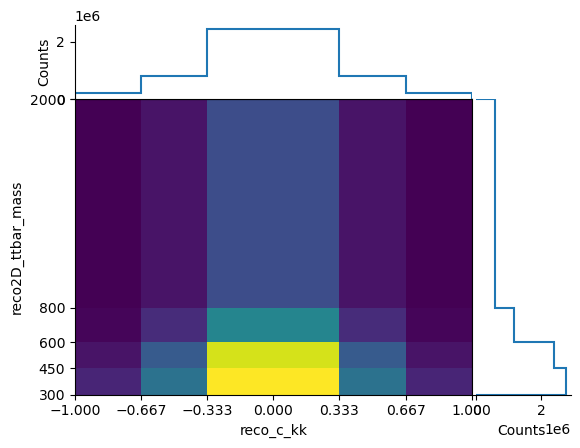

In [102]:
reco2D = compute_reco("c_kk_vs_ttbar_mass", reco_axes+reco_axes_2D, [vars_dict["c_kk"]["val_8"]]+[vars2D_dict["ttbar_mass"]["val_8"]], [step8['eventWeight']], True)
reco2D.plot2d_full()
#reco2D.view(flow=True)

In [ ]:
step0 = ak.Array(
    ak.zip( dict( (var, step0tree[var].array()) for var in tree_vars ) )
)

step8 = ak.Array(
    ak.zip( dict( (var, step8tree[var].array()) for var in tree_vars ) )
)

In [ ]:
resmat2D = compute_response_matrix("ll_cHel", 
                                   gen_axes+gen_axes_2D, 
                                   reco_axes+reco_axes_2D, 
                                   [vars_dict["ll_cHel"]["gen_val_8"],vars2D_dict["ttbar_mass"]["gen_val_8"]], 
                                   [vars_dict["ll_cHel"]["val_8"],vars2D_dict["ttbar_mass"]["val_8"]], 
                                   [vars_dict["ll_cHel"]["gen_val_0"],vars2D_dict["ttbar_mass"]["gen_val_0"]], 
                                   [step8['trueLevelWeight']], 
                                   [step8['eventWeight']], 
                                   [step0['trueLevelWeight']])



resmat2D[:,1,:,1].plot2d_full()

i_range = resmat2D.view(flow=False).shape[1]
j_range = resmat2D.view(flow=False).shape[3]
m_range = resmat2D[:,0,:,0].view(flow=False).shape[0]
n_range = resmat2D[:,0,:,0].view(flow=False).shape[1]

resmat2D_unwrapped_values = np.zeros((i_range*m_range,j_range*n_range))
resmat2D_unwrapped_variances = np.zeros((i_range*m_range,j_range*n_range))

for i in range(0,i_range):
    for j in range(0,j_range):
        #print(resmat2D.view[:,i,:,j](flow=False))
        for m in range(0,m_range):
            for n in range(0,n_range):
                #print(i*m_range + m,j*n_range + n)
                resmat2D_unwrapped_values[i*m_range + m,j*n_range + n] = resmat2D.values(flow=False)[m,i,n,j]
                resmat2D_unwrapped_variances[i*m_range + m,j*n_range + n] = resmat2D.variances(flow=False)[m,i,n,j]
#for m in range(0,resmat2D[:,1,:,1].view(flow=False).shape[0]):
#    for n in range(0,resmat2D[:,1,:,1].view(flow=False).shape[1]):
#        print(resmat2D.view(flow=False)[m,1,n,1])

#print(resmat2D_unwrapped_values)

In [ ]:
h_resmat_2D = hist.Hist(
    hist.axis.Regular(i_range*m_range, 0, i_range*m_range, name="gen", label="gen", underflow=True, overflow=True),
    hist.axis.Regular(j_range*n_range, 0, j_range*n_range, name="reco", label="reco", underflow=True, overflow=True),
    storage=hist.storage.Weight()
)

h_resmat_2D[...] = np.concatenate(
        ((resmat2D_unwrapped_values)[..., None],
         (resmat2D_unwrapped_variances)[..., None]),
        axis=2
    )
h_resmat_2D.plot2d_full()

In [ ]:
gen2D = compute_reco('ll_cHel', gen_axes+reco_axes_2D, [vars_dict["ll_cHel"]["gen_val_0"],vars2D_dict["ttbar_mass"]["gen_val_0"]], [step0['trueLevelWeight']])
#gen2D.view(flow=True)

In [ ]:
gen2D.plot2d_full()

In [ ]:
reco_axes_unwrapped = [hist.axis.Regular(vars_dict["ll_cHel"]["n_reco_bins"]*(len(vars2D_dict["ttbar_mass"]["binning"])-1), 0, vars_dict["ll_cHel"]["n_reco_bins"]*(len(vars2D_dict["ttbar_mass"]["binning"])-1), name="", label="", underflow=True, overflow=True)]
hgen2D_unwrapped = hist.Hist(
    *reco_axes_unwrapped,
    storage=hist.storage.Weight()
)

print(len(hgen2D_unwrapped.view(flow=False)))

print(len(vars2D_dict["ttbar_mass"]["binning"])-1)
print(vars_dict["ll_cHel"]["n_reco_bins"])

gen2D_unwrapped = np.zeros(vars_dict["ll_cHel"]["n_reco_bins"]*(len(vars2D_dict["ttbar_mass"]["binning"])-1))

for j in range(0,len(vars2D_dict["ttbar_mass"]["binning"])-1):
    for i in range(0,vars_dict["ll_cHel"]["n_gen_bins"]):
        #print(j*vars_dict["ll_cHel"]["n_gen_bins"]+i)
        #print(gen2D[i,j].value)
        gen2D_unwrapped[j*vars_dict["ll_cHel"]["n_gen_bins"]+i] = gen2D.values()[i,j]
        #h2D_PE.SetBinContent(i*vars_dict[var1D][0]+j,hist2D_PE[j,i].value)
        #h2D_PE.SetBinError(i*vars_dict[var1D][0]+j,np.sqrt(hist2D_PE[j,i].variance))
        
print(len(gen2D_unwrapped))
print(gen2D_unwrapped)

hgen2D_unwrapped[...] = gen2D_unwrapped[..., None]


In [ ]:
print(step0.gen_l_pt)
print(step0['gen_l_pt'])

In [ ]:
print(step0['gen_l_pt'])
print(step0['entry'])
len(step0['gen_l_pt'])

In [ ]:
print(visgen_step0['gen_l_pt'])
len(visgen_step0)

In [ ]:
print(step0['gen_lbar_pt'])

In [ ]:
print(step0['gen_l_eta'])

In [ ]:
print(step0['gen_lbar_eta'])

In [ ]:
print(visgen_step0['gen_b_pt'])

In [ ]:
print(step0['gen_bbar_pt'])

In [ ]:
print(visgen_step0['gen_b_eta'])

In [ ]:
print(step0['gen_bbar_eta'])

In [ ]:
[vars_dict["ll_cHel"]["val_8"]]

In [ ]:
resmat2D = compute_response_matrix("c_kk", 
                                   gen_axes+gen_axes_2D, 
                                   reco_axes+reco_axes_2D, 
                                   [vars_dict["c_kk"]["gen_val_8"],vars2D_dict["ttbar_mass"]["gen_val_8"]], 
                                   [vars_dict["c_kk"]["val_8"],vars2D_dict["ttbar_mass"]["val_8"]], 
                                   [vars_dict["c_kk"]["gen_val_0"],vars2D_dict["ttbar_mass"]["gen_val_0"]], 
                                   [step8['trueLevelWeight']], 
                                   [step8['eventWeight']], 
                                   [step0['trueLevelWeight']])

print(resmat2D.view(flow=True)[0][:][:][:])
print(resmat2D.view(flow=True)[:][0][:][:])
print(resmat2D.view(flow=True)[:][:][0][:])
print(resmat2D.view(flow=True)[:][:][:][0])

print(resmat2D.view(flow=True)[resmat2D.view(flow=True).shape[0]-2][:][:][:])
print(resmat2D.view(flow=True)[:][resmat2D.view(flow=True).shape[1]-2][:][:])
print(resmat2D.view(flow=True)[:][:][resmat2D.view(flow=True).shape[2]-2][:])
print(resmat2D.view(flow=True)[:][:][:][resmat2D.view(flow=True).shape[3]-2])


In [ ]:
i_range = resmat2D.view(flow=True).shape[1]-2
j_range = resmat2D.view(flow=True).shape[3]-2
m_range = resmat2D[:,0,:,0].view(flow=True).shape[0]-2
n_range = resmat2D[:,0,:,0].view(flow=True).shape[1]-2

resmat2D_unwrapped_values = np.zeros(((i_range)*(m_range)+2,(j_range)*(n_range)+2))
resmat2D_unwrapped_variances = np.zeros(((i_range)*(m_range)+2,(j_range)*(n_range)+2))

for i in range(1,i_range+1):
    for j in range(1,j_range+1):
        for m in range(1,m_range+1):
            for n in range(1,n_range+1):
                #print(i,m,(i-1)*(m_range) + m)
                resmat2D_unwrapped_values[(i-1)*(m_range) + m,(j-1)*(n_range) + n] = resmat2D.values(flow=True)[m,i,n,j]
                resmat2D_unwrapped_variances[(i-1)*(m_range) + m,(j-1)*(n_range) + n] = resmat2D.variances(flow=True)[m,i,n,j]

# Underflow for gen axes only.  No true underflow and no overflow whatsoever; just generated events that were not reconstructed in underflow bins.
for i in range(1,i_range+1):
    for m in range(1,m_range+1):
        #print(i,m,(i-1)*(m_range) + m)
        resmat2D_unwrapped_values[(i-1)*(m_range) + m,0] = resmat2D.values(flow=True)[m,i,0,0]
        resmat2D_unwrapped_variances[(i-1)*(m_range) + m,0] = resmat2D.variances(flow=True)[m,i,0,0]

# not necessary because no true underflow?
#for i in range(0,i_range+1):
#    resmat2D_unwrapped_values[(i)*(m_range) + 0,0] = resmat2D_unwrapped_values[(i)*(m_range) + 0,0] + resmat2D.values(flow=True)[0,i,0,0]
#    resmat2D_unwrapped_variances[(i)*(m_range) + 0,0] = resmat2D_unwrapped_variances[(i)*(m_range) + 0,0] + resmat2D.variances(flow=True)[0,i,0,0]
#for m in range(0,m_range+1):
#    resmat2D_unwrapped_values[m,0] = resmat2D_unwrapped_values[m,0] + resmat2D.values(flow=True)[m,0,0,0]
#    resmat2D_unwrapped_variances[m,0] = resmat2D_unwrapped_variances[m,0] + resmat2D.variances(flow=True)[m,0,0,0]

    
h_resmat_2D = hist.Hist(
    hist.axis.Regular((i_range)*(m_range), 0, (i_range)*(m_range), name="gen", label="gen", underflow=True, overflow=True),
    hist.axis.Regular((j_range)*(n_range), 0, (j_range)*(n_range), name="reco", label="reco", underflow=True, overflow=True),
    storage=hist.storage.Weight()
)

h_resmat_2D[...] = np.concatenate(
        ((resmat2D_unwrapped_values)[..., None],
         (resmat2D_unwrapped_variances)[..., None]),
        axis=2
    )
h_resmat_2D.plot2d_full()
#h_resmat_2D.plot()
h_resmat_2D.view(flow=True)

In [ ]:
h_resmat_2D.view(flow=True)[3,3]

In [ ]:
def Unwrap_2D_ResMat(resmat2D):

    i_range = resmat2D.view(flow=True).shape[1]-2
    j_range = resmat2D.view(flow=True).shape[3]-2
    m_range = resmat2D[:,0,:,0].view(flow=True).shape[0]-2
    n_range = resmat2D[:,0,:,0].view(flow=True).shape[1]-2

    resmat2D_unwrapped_values = np.zeros(((i_range)*(m_range)+2,(j_range)*(n_range)+2))
    resmat2D_unwrapped_variances = np.zeros(((i_range)*(m_range)+2,(j_range)*(n_range)+2))

    for i in range(1,i_range+1):
        for j in range(1,j_range+1):
            for m in range(1,m_range+1):
                for n in range(1,n_range+1):
                    resmat2D_unwrapped_values[(i-1)*(m_range) + m,(j-1)*(n_range) + n] = resmat2D.values(flow=True)[m,i,n,j]
                    resmat2D_unwrapped_variances[(i-1)*(m_range) + m,(j-1)*(n_range) + n] = resmat2D.variances(flow=True)[m,i,n,j]

    # Underflow for gen axes only.  No true underflow and no overflow whatsoever; just generated events that were not reconstructed in underflow bins.
    for i in range(1,i_range+1):
        for m in range(1,m_range+1):
            resmat2D_unwrapped_values[(i-1)*(m_range) + m,0] = resmat2D.values(flow=True)[m,i,0,0]
            resmat2D_unwrapped_variances[(i-1)*(m_range) + m,0] = resmat2D.variances(flow=True)[m,i,0,0]
    
    resmat2D_unwrapped = hist.Hist(
        hist.axis.Regular((i_range)*(m_range), 0, (i_range)*(m_range), name="gen", label="gen", underflow=True, overflow=True),
        hist.axis.Regular((j_range)*(n_range), 0, (j_range)*(n_range), name="reco", label="reco", underflow=True, overflow=True),
        storage=hist.storage.Weight()
    )

    resmat2D_unwrapped[...] = np.concatenate(
        ((resmat2D_unwrapped_values)[..., None],
         (resmat2D_unwrapped_variances)[..., None]),
        axis=2
    )
    
    return resmat2D_unwrapped

In [74]:
[[3][0],[3][1:]]

[3, []]

In [ ]:
def compute_response_matrix(var_name, gen_axes, reco_axes, gen_step8_data, step8_data, gen_step0_data, gen_step8_weights, step8_weights, gen_step0_weights):

    axes = gen_axes + reco_axes

    h_response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())

    # fill the reconstructed events
    h_response_matrix.fill(*gen_step8_data + step8_data, weight=step8_weights)
    
    remove_underoverflow(h_response_matrix.values(flow=True))    
    remove_underoverflow(h_response_matrix.variances(flow=True))

    # fill the generator level events in the reconstruction underflow bin
    # this is back at step0 so that we can unfold back to full phase space
    h_response_matrix.fill(*gen_step0_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step0_data[0])) for j in range(0,len(reco_axes))], weight=gen_step0_weights)

    # next create a separate response matrix to fill the reco weights
    # this is because we need to subtract the entries AND variances and can't
    # do that with a "simple" negative weight (this would only subtract entries,
    # variances are sum of weights squared)
    h__response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())

    # fill this new matrix
    h__response_matrix.fill(*gen_step8_data + [(reco_axes[j][0][0] - 1)*np.ones(len(gen_step8_data[0])) for j in range(0,len(reco_axes))], weight=step8_weights)

    # set values and variances equal to the difference between response_matrix
    # and _response_matrix to account for these events that aren't reconstructed
    h_response_matrix[...] = np.concatenate(
        ((h_response_matrix.values(flow=True) - h__response_matrix.values(flow=True))[..., None],
         (h_response_matrix.variances(flow=True) - h__response_matrix.variances(flow=True))[..., None]),
        axis=len(axes)
    )

    return h_response_matrix
